In [1]:
import numpy as np
import pickle
from copy import deepcopy
from scipy.interpolate import interp1d
from astropy.table import Table
import astropy.constants as const
import astropy.io.ascii as asci

In [2]:
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
fs = 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
z = 0.018
d_kpc = cosmo.luminosity_distance([z])[0].value * 1e+3
d_cm = d_kpc * 1e+3 * const.pc.cgs.value
scale = 4 * np.pi * d_cm**2 

In [4]:
def planck_nu(nu, Tbb, Rbb):
    h = 6.62607E-27
    c = 2.99792458E10
    k_B = 1.38064852E-16
    temp = np.exp(h*nu/(k_B*Tbb))
    temp = np.array(temp)
    Inu = 2*h/c**2 * nu**3 / (temp-1) # erg/cm2/Hz/sr/s
    Lnu = (np.pi * Inu) * (4. * np.pi * Rbb**2) # erg/Hz/s
    nuLnu = nu * Lnu # erg/s
    return nuLnu  

In [5]:
def get_spectrum(num = 1, filename = "../data/Xray_yao_reduction/BestFit.qdp"):
    f = open(filename)
    lines = f.readlines()
    f.close()

    lines = lines[3:]
    sps = []
    count = 0
    for j in range(len(lines)):
        x =  lines[j]
        if x[:11] == 'NO NO NO NO':
            count +=1
            if count==num:
                break
            else:
                sps = []
        else:
            sps.append(x)
    return asci.read(sps)

In [6]:
def plot_uvopt(ax, myphase = 150, color = "forestgreen", phase="A", dophase = "A"):
    tb = asci.read("../data/opt_lc/phase_lum.dat")
    subfilename = "../data/opt_lc/subphase_lum.dat"
    subtb = asci.read(subfilename)
    with open('../data/opt_lc/waveinfo.pickle', 'rb') as handle:
        waveinfo = pickle.load(handle)
    filters = waveinfo["filters"]
    wv_filts = waveinfo["wv_filts"]
    nus_obs = 3e+10 / (wv_filts * 1e-8)
    nus = nus_obs * (1+z)
    
    filename_save = "../data/opt_lc/bbpars_ebv_0.00.dat"
    bbtb = asci.read(filename_save)
    
    subfilename_save = "../data/opt_lc/subbbpars_ebv_0.00.dat"
    subbbtb = asci.read(subfilename_save)

    ind = np.argsort(abs(tb["phase"].data-myphase))[0]
    indbb = np.argsort(abs(bbtb["phase"].data-myphase))[0]
    
    subind = np.argsort(abs(subtb["phase"].data-myphase))[0]
    subindbb = np.argsort(abs(subbbtb["phase"].data-myphase))[0]
    
    mainphase = tb["phase"].data[ind]
    subphase = subtb["phase"].data[subind]
    
    sep = abs(myphase - mainphase)
    subsep = abs(myphase - subphase)
    
    if sep  < subsep:
        dosub = False
    else:
        dosub = True
    
    verbose = False
    if verbose:
        print ("Specified phase = %d, phase in main table = %d, phase in sub table= %d"%(myphase, mainphase, subphase))
        if dosub:
            print ("  --> use sub table")
        else:
            print ("  --> use main table")
    
    lums = np.zeros(len(filters))
    elums = np.zeros(len(filters))
    
    for j in range(len(filters)):
        myfilter = filters[j]
        if dosub:
            lums[j] = subtb["%s-lum"%myfilter][subind] 
            elums[j] = subtb["%s-elum"%myfilter][subind] 
        else:
            lums[j] = tb["%s-lum"%myfilter][ind] 
            elums[j] = tb["%s-elum"%myfilter][ind] 
        
    if dosub:
        Topt = subbbtb["T"][subindbb]
        Ropt = subbbtb["R"][subindbb]
    else:
        Topt = bbtb["T"][indbb]
        Ropt = bbtb["R"][indbb]
    if verbose:
        print ("  T = %d K, R = %.2f e+14 cm"%(Topt, Ropt/1e+14))
    nus_plot = np.logspace(14.2, 15.7)
    nuLnu_plot = planck_nu(nus_plot, Topt, Ropt)
    ix = (elums / lums) < 0.5
    if phase == dophase:
        zorder = 5
        alpha = 1
        ax.errorbar(nus[ix], lums[ix]/scale, elums[ix]/scale, fmt = ".", color = color,
                    markeredgecolor = "k",
                    markeredgewidth = 0.4, zorder = zorder, markersize = ms+2,
                    alpha=alpha)
        lw = 2
    else:
        zorder = 1
        alpha = 0.2
        lw = 0.8
        ax.errorbar(nus[ix], lums[ix]/scale, elums[ix]/scale, fmt = ".", color = color,
                    zorder = zorder, markersize = ms-2, alpha=alpha)
    ix1 = nus_plot > 1.8e+15
    ix2 = nus_plot < 5e+14
    ix_obs = (nus_plot < 2e+15)&(nus_plot > 4e+14)
    ax.plot(nus_plot[ix_obs], nuLnu_plot[ix_obs]/scale, color = color, linewidth = lw,
            zorder = zorder, alpha=alpha)
    ax.plot(nus_plot[ix1], nuLnu_plot[ix1]/scale, color = color, linewidth = lw,
            zorder = zorder, alpha=alpha/2)
    ax.plot(nus_plot[ix2], nuLnu_plot[ix2]/scale, color = color, linewidth = lw,
            zorder = zorder, alpha=alpha/2)

In [7]:
def plot_xrt(ax, xfile1a, xfile1b, xfileubb, xfileupl, color = "k", phase = "A", dophase = "A"):
    if phase == dophase:
        zorder = 5
        alpha = 1
        lw = 2
        mec = "k"
    else:
        lw = 0.8
        zorder = 1
        alpha = 0.2
        mec = color
    if phase!="A":
        mod1 = get_xray_nufnu(num = 1, ycol = "col5", filename=xfile1a)
        mod2_bb = get_xray_nufnu(num = 1, ycol = "col3", filename=xfileubb)
        mod2_pl = get_xray_nufnu(num = 1, ycol = "col3", filename=xfileupl)
    
        mod2 = deepcopy(mod2_bb)
        for ycol in ["fnu", "nufnu", "EfE"]:
            #mod2_pl[ycol][ix2] = np.nan
            mod2[ycol] = mod2_bb[ycol] + mod2_pl[ycol]
        
        df1 = get_xray_nufnu(num = 1, filename=xfile1b) 
        myfunc_unabs = interp1d(mod2["nu"], mod2["nufnu"])
        myfunc_abs = interp1d(mod1["nu"], mod1["nufnu"])
        if phase==dophase:
            nu_0p5keV = 0.5 * 1e+3 * 1.6e-12 / const.h.cgs.value
            nu_2keV = 2 * 1e+3 * 1.6e-12 / const.h.cgs.value
            factor1 = myfunc_unabs(nu_0p5keV/(1+z)) / myfunc_abs(nu_0p5keV/(1+z))
            factor2 = myfunc_unabs(nu_2keV/(1+z)) / myfunc_abs(nu_2keV/(1+z))
            print ("")
            print ("0.5 keV:", factor1)
            print ("2 keV:", factor2)
        factor = myfunc_unabs(df1["nu"].values) / myfunc_abs(df1["nu"].values) 
    
        ax.errorbar(df1["nu"]*(1+z), df1["nufnu"] * factor, 
                    df1["nufnu_unc"] * factor, xerr = df1["nu_unc"]*(1+z), 
                    fmt = "s", color = color, markersize = 3, linewidth = lw,
                    zorder=zorder, alpha =alpha, markeredgecolor = mec,
                    markeredgewidth = 0.2)
    else:
        nufnu = 1e-13
        print (phase, dophase, lw)
        ax.plot([7e+16, 1e+18], [nufnu, nufnu], color = color, linestyle = "-",
                linewidth = lw, alpha =alpha)
        ax.arrow(2.7e+17, nufnu, 0, -nufnu*0.3, color = color, head_width = 5e+16,
                 head_length = nufnu*0.1, alpha =alpha )

In [8]:
def get_xray_nufnu(num = 1, filename="../data/Xray_yao_reduction/BestFit.qdp", ycol = None, 
                   fnu_unc_max = None, fnu_min = None, remove_softline = False):
    sp5 = get_spectrum(num = num, filename=filename)
    E = sp5["col1"] # keV
    nu = E * 1.6e-9 / const.h.cgs.value # Hz
    if ycol is None:
        E_unc = sp5["col2"] 
        nu_unc = E_unc * 1.6e-9 / const.h.cgs.value
        EfE = sp5["col3"] # keV^2 photon / cm^2 / s / keV
        EfE_unc = sp5["col4"]
        nufnu = EfE * 1.6e-9 # Hz erg / cm^2 / s / Hz
        nufnu_unc = EfE_unc * 1.6e-9
        fnu = nufnu / nu
        fnu_unc = nufnu_unc / nu
        tb = Table(data = [E, E_unc, EfE, EfE_unc, nu, nu_unc, fnu, fnu_unc, nufnu, nufnu_unc], 
                   names = ["E", "E_unc", "EfE", "EfE_unc",
                            "nu", "nu_unc", "fnu", "fnu_unc", "nufnu", "nufnu_unc"])
        if fnu_unc_max is not None:
            ix = tb["fnu_unc"] < fnu_unc_max
            tb = tb[ix]
    else:
        EfE = sp5[ycol] # keV^2 photon / cm^2 / s / keV
        nufnu = EfE * 1.6e-9 # Hz erg / cm^2 / s / Hz
        fnu = nufnu / nu
        tb = Table(data = [nu, fnu, E, EfE], names = ["nu", "fnu", "E", "EfE"])
    if fnu_min is not None:
        ix = tb["fnu"] > fnu_min
        tb = tb[ix]
    
    if remove_softline == True:
        ix = (tb["E"]>0.525)&(tb["E"]<0.53)
        tb = tb[~ix]
    tb = tb.to_pandas()
    tb["nufnu"] = tb["nu"] * tb["fnu"]
    
    return tb

In [9]:
def plot_sed(ax, dophase = "A"):
    colormap = plt.cm.plasma
    colorA = "silver"
    colorB = "silver"
    colorC = "silver"
    colorD = "silver"
    colorE = "silver"
    if dophase=="A":
        colorA = colormap(0.9)
        tcolor = colorA 
    if dophase=="B":
        colorB = colormap(0.7)
        tcolor = colorB
    if dophase=="C":
        colorC = colormap(0.5)
        tcolor = colorC
    if dophase=="D":
        colorD = colormap(0.3)
        tcolor = colorD
    if dophase=="E":
        colorE = colormap(0.1)
        tcolor = colorE
    
    plot_uvopt(ax, myphase = -19, color = colorA, phase = "A", dophase = dophase)
    plot_uvopt(ax, myphase = 74, color = colorB, phase = "B", dophase = dophase)
    plot_uvopt(ax, myphase = 147, color = colorC, phase = "C", dophase = dophase)
    plot_uvopt(ax, myphase = 260, color = colorD, phase = "D", dophase = dophase)
    plot_uvopt(ax, myphase = 310, color = colorE, phase = "E", dophase = dophase)
    
    # phase A
    plot_xrt(ax, "", "", "", "", color = colorA, phase = "A", dophase = dophase)
    
    # phase B
    xfile1a = "../data/xrt/spec/s1/eeufspec_ratio_fix_1_100.qdp"
    xfile1b = "../data/xrt/spec/s1/eeufspec_ratio_fix_3_100.qdp"
    xfileubb = "../data/xrt/spec/s1/unabs_mod_bb.qdp"
    xfileupl = "../data/xrt/spec/s1/unabs_mod_pl.qdp"
    plot_xrt(ax, xfile1a, xfile1b, xfileubb, xfileupl, color = colorB, phase = "B", dophase = dophase)
    
    # phase C
    xfile1a = "../data/xrt/spec/phaseC/eeufspec_ratio_fix_1_100.qdp"
    xfile1b = "../data/xrt/spec/phaseC/eeufspec_ratio_fix_8_100.qdp"
    xfileubb = "../data/xrt/spec/phaseC/unabs_mod_bb.qdp"
    xfileupl = "../data/xrt/spec/phaseC/unabs_mod_pl.qdp"
    plot_xrt(ax, xfile1a, xfile1b, xfileubb, xfileupl, color = colorC, phase = "C", dophase = dophase)
    
    # phase D
    xfile1a = "../data/xrt/spec/phaseD/eeufspec_ratio_fix_1_100.qdp"
    xfile1b = "../data/xrt/spec/phaseD/eeufspec_ratio_fix_10_100.qdp"
    xfileubb = "../data/xrt/spec/phaseD/unabs_mod_bb.qdp"
    xfileupl = "../data/xrt/spec/phaseD/unabs_mod_pl.qdp"
    plot_xrt(ax, xfile1a, xfile1b, xfileubb, xfileupl, color = colorD, phase = "D", dophase = dophase)
    
    # phase E
    xfile1a = "../data/xrt/spec/phaseE/eeufspec_ratio_fix_1_100.qdp"
    xfile1b = "../data/xrt/spec/phaseE/eeufspec_ratio_fix_5_100.qdp"
    xfileubb = "../data/xrt/spec/phaseE/unabs_mod_bb.qdp"
    xfileupl = "../data/xrt/spec/phaseE/unabs_mod_pl.qdp"
    plot_xrt(ax, xfile1a, xfile1b, xfileubb, xfileupl, color = colorE, phase = "E", dophase = dophase)
    
    xmin = 1e+14
    xmax = 3e+18
    ax.set_xlim(xmin, xmax)
    ax.semilogx()
    ax.semilogy()
    ymin = 4e-14
    ymax = 9e-11
    if dophase == "A":
        ymax = 1e-10
    ax.set_ylim(ymin, ymax)
    ax.tick_params(which = 'major', length = 4, top=True, right=True, direction = "in")
    ax.tick_params(which = 'minor', length = 2, top=True, right=True, direction = "in")
    #ax.legend(ncol = 5, loc = "upper center")
    if dophase!="E":
        ax.set_xticklabels([])
        
    ax.text(xmax*0.5, ymax*0.3, dophase, color = tcolor, weight="bold")

A A 2
A B 0.8

0.5 keV: 2.1342353648277133
2 keV: 1.054109662298189
A C 0.8

0.5 keV: 2.1292465864592787
2 keV: 1.0481649483514521
A D 0.8

0.5 keV: 2.1288254409564615
2 keV: 1.048156060075302
A E 0.8

0.5 keV: 2.1293351910644684
2 keV: 1.04828422806101


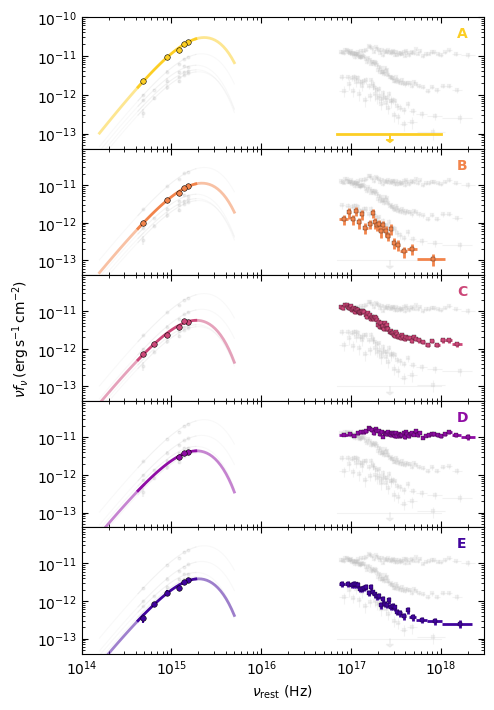

In [10]:
    fig = plt.figure(figsize = (4.8, 7.))
    gs = fig.add_gridspec(5, 1, hspace=0.0, wspace = 0, height_ratios=[1.05,1.,1,1,1])
    axs = gs.subplots(sharex=True)
    
    plot_sed(axs[0], dophase = "A")
    plot_sed(axs[1], dophase = "B")
    plot_sed(axs[2], dophase = "C")
    plot_sed(axs[3], dophase = "D")
    plot_sed(axs[4], dophase = "E")
    
    axs[4].set_xlabel(r"$\nu_{\rm rest}$"+" (Hz)")
    axs[2].set_ylabel(r"$\nu f_{\nu}\, (\rm erg\,s^{-1}\, cm^{-2})$")
    
    plt.tight_layout(rect = (-0.03, -0.02, 1.02, 1.01))